In this notebook we will discuss about simple router in langgraph.

# Router

## Review

We built a graph that uses `messages` as state and a chat model with bound tools.

We saw that the graph can:

* Return a tool call
* Return a natural language response

## Goals

We can think of this as a router, where the chat model routes between a direct response or a tool call based upon the user input.

This is a simple example of an agent, where the LLM is directing the control flow either by calling a tool or just responding directly. 

![Screenshot 2024-08-21 at 9.24.09 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbac6543c3d4df239a4ed1_router1.png)

Let's extend our graph to work with either output! 

For this, we can use two ideas:

(1) Add a node that will call our tool.

(2) Add a conditional edge that will look at the chat model output, and route to our tool calling node or simply end if no tool call is performed. 



In [1]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

In [2]:
load_dotenv()

True

In [3]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b


# bind the tools to the LLM
llm = ChatOpenAI(model="gpt-4o")
tools = [multiply]
llm_with_tools = llm.bind_tools(tools)

 We use the [built-in `ToolNode`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#toolnode) and simply pass a list of our tools to initialize it. 
 
 We use the [built-in `tools_condition`](https://langchain-ai.github.io/langgraph/reference/prebuilt/?h=tools+condition#tools_condition) as our conditional edge.

In [4]:
# define the node
def tool_calling_llm(state: MessagesState):
    return {"messages": llm_with_tools.invoke(state["messages"])}

In [5]:
# MessagesState is same as annotated state of list of messages with reducers

In [6]:
# build the graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
# we add tool node to execute the tool call
builder.add_node("tools", ToolNode(tools=tools))
# add edges and conditional edges
builder.add_edge(START, "tool_calling_llm")
# Use in the conditional_edge to route to the ToolNode if the last message has tool calls. Otherwise, route to the end.
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)

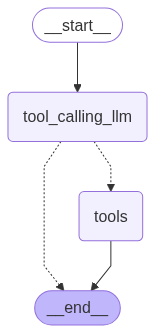

In [7]:
# compile and view the graph
graph = builder.compile()
display(Image(graph.get_graph().draw_mermaid_png()))

In [8]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Hello, what is 2 multiplied by 2?")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello, what is 2 multiplied by 2?
================================== Ai Message ==================================
Tool Calls:
  multiply (call_bSEQdGUzl00spHQ9GEdBpE4r)
 Call ID: call_bSEQdGUzl00spHQ9GEdBpE4r
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: multiply

4


########################### END OF SCRIPT ###########################